In [1]:
from scipy.optimize import curve_fit # curve fitting
import numpy as np # math and data structure
import matplotlib.pyplot as plt # ploting
import trackpy as tp # mostly linking
import pandas as pd # data structrue
from scipy import stats   # for data analysis
import os, sys   # to load data
from copy import deepcopy

### select files

In [2]:
fdir = 'C:/' # set the "Select Files..." dialog start directory to the notebook directory
def openFilesDialog(fdir):
    from PyQt5.QtWidgets import QApplication,QFileDialog
    app = QApplication([dir])
    files = QFileDialog.getOpenFileNames(None, "Select Files...", fdir, filter='HDF5 Files (*.h5);;All Files (*)',options=QFileDialog.DontUseNativeDialog)
    return files[0]

In [3]:
## gui data selection
#look for files with name
files = openFilesDialog(fdir)
fdir = os.path.dirname(files[0])

In [4]:
## alternatively
## load data
#dataset = '\..\..\many_JP_BOX_WF14mW_024'
#look for files with name
#file_list = []
#for file in glob.glob(dataset + '*_spots.h5'):
#    print(file)
#    file_list.append(file)

### load meta data

In [5]:
#get metadata of a specified file
with pd.HDFStore(files[0]) as store:
    
    
    
    metadata = store['metadata']#.to_dict('records')[0]
    store.close()
    
metadata

binning  dimx  dimy  exposure  frames                 t_method  \
0        1   512   512      0.03     500  JP tracker multiple THs   

   t_threshold  t_area_min  t_area_max  t_area_max_pair  t_area_min_pair  \
0         1300          50         300              450              250   

   t_close_pair_checkBox  t_area_min_ellipticity_pair  t_area_max_ellipticity  
0                      2                          0.5                     0.5

In [6]:
exposure_time = float(metadata.exposure)
dimx = int(metadata.dimx)

In [7]:
pxl_mu = 1
pxl_mu = 1

### load data

In [8]:
del spots, f

NameError: name 'spots' is not defined

In [24]:
spots = pd.DataFrame()
for i, file in enumerate(files):
    with pd.HDFStore(file) as store:
        spots = store['spots']
        store.close()
        spots['series_No'] = i
        spots.rename(columns = {'frame':'frame_rel'},inplace = True)
        spots['frame'] = spots['frame_rel']
        spots['file'] = file
    if i == 0:   
        f = spots
    else:
        spots['frame'] += f['frame'].max() + 50  # this is used to discriminate the different tdms seqences
        f = f.append(spots)
f['i'] = list(range(len(f)))
f = f.set_index('i',drop = False)  # set the index that was not set before
#f['i0'] = f.index
f.drop(columns=['orientation'],inplace=True)  # this is from ellipticity and is not needed here
print(f.columns)
f.head()

Index(['ClosePairStatus', 'area', 'bbox', 'eccentricity', 'frame_rel',
       'major_axis_length', 'max_intensity', 'minor_axis_length', 'phi',
       'summed_intensity', 'x', 'y', 'series_No', 'frame', 'file', 'i'],
      dtype='object')


ClosePairStatus  area                  bbox  eccentricity  frame_rel  \
i                                                                         
0            False   185  (103, 159, 118, 175)      0.243545          0   
1            False   166  (109, 348, 123, 362)      0.200406          0   
2            False   164    (114, 41, 128, 56)      0.350555          0   

   major_axis_length  max_intensity  minor_axis_length       phi  \
i                                                                  
0          15.582480          13243          15.113287  0.289419   
1          14.679861          14437          14.382050  2.695082   
2          14.939661          11674          13.991622 -3.118738   

   summed_intensity           x           y  series_No  frame  \
i                                                               
0         1033705.0  166.010811  109.951351          0      0   
1          871492.0  354.439759  115.560241          0      0   
2          755676.0   47.810976  120.152439          0      0   

                                                file  i  
i                                                        
0  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...  0  
1  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...  1  
2  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...  2

In [25]:
print('max pseudo frame',np.max(f.frame))
print('N particles in total',len(f))

max pseudo frame 21910
N particles in total 424002


### flag active particles
in active region with safety buffer

In [26]:
center = dimx//2 #pxl
buffer = 5 #pxl
R_active = 135 #pxl
f['active'] = R_active - buffer - np.sqrt((f.x-center)**2 + (f.y-center)**2) > 0 #boolian
f_active = deepcopy(f[f.active == True])
metadata['active_radius'] = R_active + buffer

### find pairs in active data

In [118]:
# add max event radius and > outer exclusion radius feature

event_radius = 35 #7 / pxl_mu# near neighbor
f_active['pair_event'] = False   # 1 is the first partner , 2 is the second partner
f_active['partner'] = np.nan
f_active['pair_dist'] = np.nan
f_active['i_pair'] = np.nan
f_active['xij'] = np.nan
f_active['yij'] = np.nan
pair_counter = 0
for frame in f_active.frame.unique():
    nn_collection = [] # near neighbor
    dist_collection = []
    #f_frame = f_active[f_active.frame == frame]
    x_list = np.array(f_active[f_active.frame == frame].x)
    y_list = np.array(f_active[f_active.frame == frame].y)
    particle_index_list = np.array(f_active[f_active.frame == frame].index)
    dist_list = np.zeros(len(x_list))
    ## from here all is done with new index (order of x_list)
    #print('frame ',frame)
    #print('particles N ',len(x_list))
    for p1 in range(len(x_list)): #for every particle in frame find all near neighbors
        near_neighbor_list = []
        dist_list = []
        for p2 in range(len(x_list)):
            if p1 != p2 and np.sqrt((x_list[p1]-x_list[p2])**2+(y_list[p1]-y_list[p2])**2) <= event_radius:
                near_neighbor_list.append(p2)
                dist_list.append(np.sqrt((x_list[p1]-x_list[p2])**2+(y_list[p1]-y_list[p2])**2))
        nn_collection.append(near_neighbor_list)
        dist_collection.append(dist_list)
    #index_list_for_inner = []
    #index_list_one_radius = []
    already_had_list = []
    for p1 in range(len(x_list)):
        if p1 in already_had_list:
            continue
        trigger = False
        already_had_list += nn_collection[p1]
        if len(nn_collection[p1])==1:
            if len(nn_collection[ nn_collection[p1][0] ]) == 1:
                p2 = nn_collection[p1][0]
                ip1 = particle_index_list[p1]
                ip2 = particle_index_list[nn_collection[p1][0]]
                f_active.loc[ip1,'pair_event' ]= 1
                f_active.loc[ip2,'pair_event' ]= 2
                f_active.loc[ip1,'partner' ]= ip2
                f_active.loc[ip2,'partner']= ip1
                f_active.loc[ip1,'pair_dist' ]= dist_collection[p1][0]
                f_active.loc[ip2,'pair_dist']= dist_collection[p1][0]
                f_active.loc[ip1,'i_pair' ]= pair_counter
                f_active.loc[ip2,'i_pair']= pair_counter
                pair_counter +=1
                f_active.loc[ip1,'xij' ] = f_active.loc[ip2].x - f_active.loc[ip1].x
                f_active.loc[ip2,'yij'] = f_active.loc[ip1].y - f_active.loc[ip2].y
                
print('found ',f_active[f_active.pair_event != False].shape[0]/2,'event pairs')
f_events = deepcopy(f_active[f_active.pair_event != False])

metadata['event_radius'] = event_radius

found  13443.0 event pairs


In [119]:
print('max pseudo frame',np.max(f_events.frame))

max pseudo frame 21886


### link event trajectories
and filter to short traj (at least one displacement)

Frame 21886: 2 trajectories present.
N events: 1607


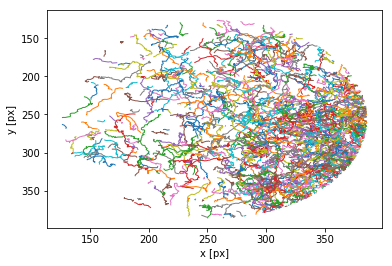

In [120]:
f_events= tp.link_df(f_events,7,memory = 0);
print('N events:', f_events['particle'].nunique())
tp.plot_traj(f_events)
f_events = f_events.set_index('i',drop = False)  #set index again, trackpy does frame as index

In [125]:
f_events.to_pickle('f_events')

In [4]:
f_events = pd.read_pickle('f_events')

In [5]:
print('No. of events',len(f_events))

No. of events 26886


### calc pair distance 
- already done before

In [6]:
#f_events['pair_dist2'] = 0
#for i in np.array(f_events.index):
#    f_events.loc[i,['pair_dist2']] = np.sqrt( (f_events.loc[i].x - f_events.loc[f_events.loc[i].partner].x)**2
#                                                + (f_events.loc[i].y - f_events.loc[f_events.loc[i].partner].y)**2 )

### plot the pair distance distribution

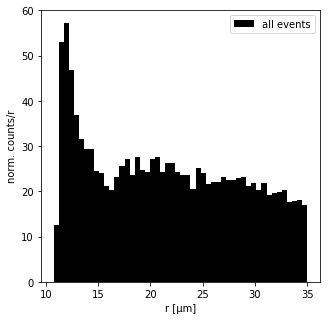

In [7]:
#from matplotlib import rc
#font = {'family' : 'monospace',
#        'weight' : 'bold',}

#rc('font', **font)  # pass in the font dict as kwargs
fig, ax = plt.subplots(1, 1,figsize=(5,5))
weigths = 1/f_events['pair_dist']
ax.hist(f_events['pair_dist'],label = 'all events',bins = 50,weights = weigths,color = 'k')
ax.legend()
ax.set_xlabel('r [µm]')
ax.set_ylabel('norm. counts/r')
plt.show()

In [8]:
f_events.set_index('i',drop = False,inplace=True)

### Calc orientation vectors

In [9]:
phi_list = np.array(f_events['phi'])
f_events['ox'] = np.sin(phi_list)
f_events['oy'] = np.cos(phi_list)

### Calc orientation projection list

In [10]:
f_events['phi_orientation_projection'] = 0
for i in np.array(f_events.index):
    f_events.loc[i,['phi_orientation_projection']] = (f_events.loc[i].ox * f_events.loc[f_events.loc[i].partner].ox
                                                    + f_events.loc[i].oy * f_events.loc[f_events.loc[i].partner].oy)

to calc the distribution of n1*n2 use: (the distribution of a functionvalue of a distributed variable)


$\rho_f = \int dx \rho(x) \delta(f-f(x)) = \int dx \rho(x) |f'(x)^{-1}| \delta(x-x(f)) $

$f(x) = nx(\phi) = \cos(\phi)$

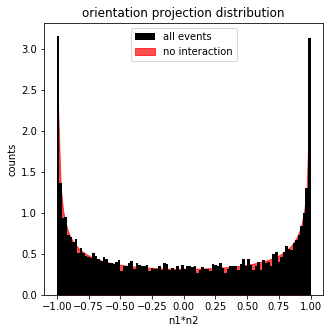

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(5,5))
H = ax.hist(f_events['phi_orientation_projection'],label = 'all events',bins = 100,density=True,color = 'k',alpha = 1)
edges = H[1]
centers = edges[:-1] + 1/2*(edges[1]-edges[0])
ax.fill_between(centers,0,1/np.abs(np.sin(np.arccos(centers)))/np.pi, label = 'no interaction',color = 'r',alpha = 0.7)
ax.legend()
ax.set_title('orientation projection distribution')
ax.set_xlabel('n1*n2')
ax.set_ylabel('counts')
plt.show()

### Calc relative angels

In [12]:
phi_ij_list = np.zeros(len(f_events.index))
for j in range(len(f_events.index)):
    i = np.array(f_events.index)[j]
    phi_ij_list[j]= f_events.loc[i].phi - f_events.loc[f_events.loc[i].partner].phi 
phi_ij_list[phi_ij_list > np.pi] += -2*np.pi
phi_ij_list[phi_ij_list < -np.pi] += 2*np.pi
f_events['phi_ij'] = phi_ij_list

### look at pairs as entities

In [13]:
f_pairs = f_events[f_events.pair_event==1]    

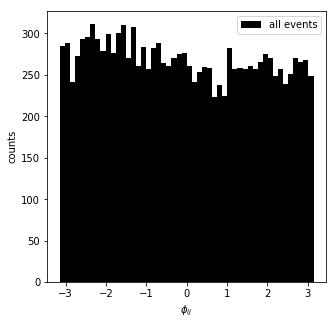

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(5,5))
ax.hist(f_pairs['phi_ij'],label = 'all events',bins = 50,color='k')
ax.legend()
ax.set_xlabel('$\phi_{ij}$')
ax.set_ylabel('counts')
plt.show()

### calc displacements

look at pairs as entities

In [ ]:
def Compute_displacement_quantity(df,quantity = 'x',framediff = 1):
    lagtime = framediff   # over how many frames the difference is taken
    mpp = 1  # for units i guess
    #df.set_index(['frame'],drop = False,inplace = True)
    pos = df.set_index(['frame', 'particle'])[quantity].unstack() # particles as columns
    #xpos = xpos.reindex(np.arange(xpos.index[0], 1 + xpos.index[-1]))  ## and fill up the missing frames with nans
    disp = mpp*pos.sub(pos.shift(lagtime)) #  do the substraction
    index_p = disp.T.index
    index_f = disp.index
    
    usefull_indices = np.argwhere(np.invert(np.isnan(disp.values)))
    d_list = np.empty(len(usefull_indices))    ### prepear the lists
    d_list[:] = np.nan
    frame_list = np.empty(len(usefull_indices))
    particle_list = np.empty(len(usefull_indices))
    for n in range(len(usefull_indices)):                        ### set all the displacements
        p = list(disp.T.index)[usefull_indices[n][1]]
        f = list(disp.index)[usefull_indices[n][0]]
        d_list[n] = disp.loc[(f,p)]
        frame_list[n] = f
        particle_list[n] = p
    
    new_quantity = 'd'+quantity
    
    ### now make a data frame to merge with the gib data frame
    tmp = pd.DataFrame({ new_quantity : d_list,
                       'frame' : frame_list,
                       'particle' : particle_list})
    #df.set_index(['frame','particle'],drop = False,inplace = True)
    df2 = pd.merge(df,tmp,on=['particle','frame'],how='outer')         ### here the data is merged
    print('done with calulation of ',new_quantity)
    return df2
framediff = 4
metadata['dispdiff'] = framediff
f_events = Compute_displacement_quantity(f_events, quantity = 'x',framediff = framediff) 
f_events = Compute_displacement_quantity(f_events, quantity = 'y',framediff = framediff)
f_events = Compute_displacement_quantity(f_events, quantity = 'pair_dist',framediff = framediff)
f_events = Compute_displacement_quantity(f_events, quantity = 'phi',framediff = framediff)
f_events.loc[f_events.dphi > np.pi,'dphi']+= -2*np.pi
f_events.loc[f_events.dphi < -np.pi,'dphi']+= 2*np.pi
f_events = Compute_displacement_quantity(f_events, quantity = 'phi_ij',framediff = framediff)
f_events.loc[f_events.dphi_ij > np.pi,'dphi_ij']+= -2*np.pi
f_events.loc[f_events.dphi_ij < -np.pi,'dphi_ij']+= 2*np.pi
f_events = Compute_displacement_quantity(f_events, quantity = 'xij',framediff = framediff)
f_events = Compute_displacement_quantity(f_events, quantity = 'yij',framediff = framediff)
f_events = Compute_displacement_quantity(f_events, quantity = 'phi_orientation_projection',framediff = framediff)

f_events.set_index('i',drop = False,inplace = True)


done with calulation of  dx
done with calulation of  dy
done with calulation of  dpair_dist
done with calulation of  dphi
done with calulation of  dphi_ij


In [142]:
f_events.columns

Index(['ClosePairStatus', 'area', 'bbox', 'eccentricity', 'frame_rel',
       'major_axis_length', 'max_intensity', 'minor_axis_length', 'phi',
       'summed_intensity', 'x', 'y', 'series_No', 'frame', 'file', 'i',
       'active', 'pair_event', 'partner', 'pair_dist', 'i_pair', 'xij', 'yij',
       'particle', 'ox', 'oy', 'phi_orientation_projection', 'phi_ij', 'dx',
       'dy', 'dpair_dist', 'dphi', 'dphi_ij', 'dxij', 'dyij',
       'dphi_orientation_projection'],
      dtype='object')

In [144]:
f_events.to_pickle('f_events_displacements')


In [17]:
f_events = pd.read_pickle('f_events_displacements')

In [20]:
f_pairs = f_events[f_events.pair_event==1]
f_disp = f_events[pd.notna(f_events.dx)]
f_pair_disp = f_disp[f_disp.pair_event==1]

### dphi statistics all events
    dphi and dphi_ij have a strange outliers at pi and -pi, check waht is wrong there!
        - you might have done a mistake with the calc of displacement

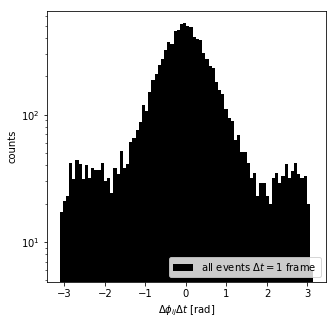

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(5,5))
ax.hist(f_pair_disp['dphi'],label = 'all events $\Delta t = 1$ frame',bins = 80,color='k')
ax.legend(loc = 4)
ax.set_xlabel('$\Delta\phi_{ij} \Delta t$ [rad]')
ax.set_ylabel('counts')
ax.set_yscale("log", nonposy='clip')
plt.show()

### distance statistics

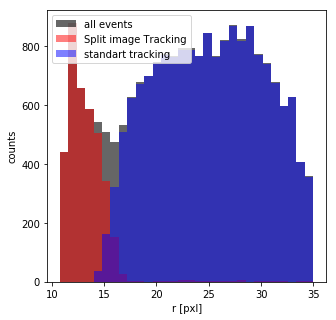

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(5,5))
#weigths = 1/f_events['pair_dist']
H = ax.hist(f_disp['pair_dist'],label = 'all events',bins = 30,color = 'k',alpha = 0.6) #,weights = weigths
ax.hist(f_disp[f_disp.ClosePairStatus ==True]['pair_dist'],label = 'Split image Tracking',color = 'r',bins = H[1],alpha = 0.5) #,weights = weigths
ax.hist(f_disp[f_disp.ClosePairStatus ==False]['pair_dist'],label = 'standart tracking',color = 'b',bins = H[1],alpha = 0.5) #,weights = weigths
ax.legend()
ax.set_xlabel('r [pxl]')
ax.set_ylabel('counts')
plt.show()

In [23]:
f_disp.iloc[0][['phi','dphi','i','frame','particle']]

phi          3.0789
dphi        2.58975
i              2844
frame           128
particle          0
Name: 2844, dtype: object

In [24]:
f_events[(f_events.particle == 0 )&(f_events.frame == 128-5)][['phi','dphi','i','frame']]

phi  dphi     i  frame
i                               
2734 -2.65245   NaN  2734    123

In [25]:
262.145455-262.965

-0.8195449999999482

### displacement of single particle along JP orientation


- to make this a neat looking graph:
    - write the mean value somewhere
    - draw a circle for the free diffusion $\sigma$
    - draw the 2D gaussian fit ellipse
    - write the $\sigma$ from free diffusion and the data ellipse ()

No handles with labels found to put in legend.


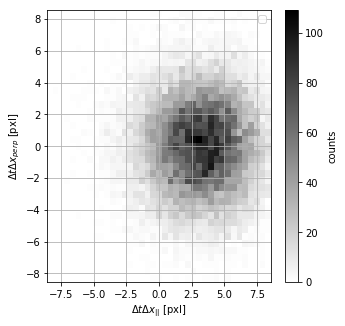

In [40]:
dx = np.array(f_disp.dx)
dy = np.array(f_disp.dy)
ox = np.array(f_disp.ox)
oy = np.array(f_disp.oy)
phi = np.array(f_disp.phi)


#dx_paralell = dx * ox + dy * oy
#dx_perp = - dx * oy + dy * ox

dx_paralell = - ( dx * np.sin(phi) + dy * np.cos(phi) )
dx_perp = - dx * np.cos(phi) + dy * np.sin(phi)

fig, ax = plt.subplots(1, 1,figsize=(5,5))
#weigths = 1/f_events['pair_dist']

max_val = np.max(np.abs(np.sqrt(dx_paralell**2+dx_perp**2)))/3*2
edges = np.linspace(-max_val,max_val,40)
H = ax.hist2d(dx_paralell,dx_perp,bins = edges,cmap = 'gray_r',label='all events')
#H = ax.hist(f_disp['pair_dist'],label = 'all events',bins = 30,color = 'k',alpha = 0.6) #,weights = weigths
plt.legend()
ax.set_xlabel('$\Delta t \Delta x_{||}$ [pxl]')
ax.set_ylabel('$\Delta t \Delta x_{perp}$ [pxl]')
fig.colorbar(H[3],label = 'counts')
plt.grid()
plt.show()

In [76]:
plt.hist2d?

### alignment analysis
look at n1*n2

do they align?
    - angle statistic of close contact (phi and phi_ij, also d...)
    - displacement statistic of close contact (pair_dist)   (do i have to care here to exclude the path bofer the )
    -



d(n1*n2)

In [169]:
R1 = 11 #pxl
R2 = 12





print('N ',len(f_disp[(f_disp.pair_dist < R2) & (f_disp.pair_dist > R1)]))







N  1101
